# Model selection

## Selecting parameters using cross-validation

As we saw, both Ridge and LASSO regression depend on a parameter $\lambda > 0$. In general, models for data can depend on millions or even billions of parameters. [Cross-validation](sec-cross-validation) is typically used in the training phase to select parameters. 

Let $f_\lambda$ be some model that depends on a parameter $\lambda$. For example, $f_\lambda$ could be Ridge regression with penalty $\lambda$. Assume we are given training data $(y_1, \mathbf{x_1}), (y_2, \mathbf{x_2}), \dots (y_n, \mathbf{x_n})$. Our goal is to choose $\lambda$ in a good way so that $f_\lambda(\mathbf{x_i}) \approx y_i$ for all $i$. Let $L(y,\hat{y})$ be a loss function to measure the error made by the model. For example, if our prediction is a one-dimensional real number, we could pick $L(y,y_i) = |y-y_i|^2$. One possible option to choose $\lambda$ would be to pick the parameter that minimizes the average error, i.e., 

$$
\widehat{\lambda} = \mathop{\textrm{argmin}}_\lambda \frac{1}{n} \sum_{i=1}^n L(y_i, f_\lambda(\mathbf{x_i})) = \mathop{\textrm{argmin}}_\lambda \frac{1}{n} \sum_{i=1}^n |y_i - f_\lambda(\mathbf{x_i})|^2. 
$$

The problem with that approach is that the model learns to predict the training data well, but may not generalize well to new data. Instead, we use a cross-validation approach to pick the parameter $\lambda$. 

Recall that in $K$-folds cross-validation, the training data is split into $K$ folds $F_1, \dots, F_K$. 

```{figure} images/cv.png
---
width: 500 px
---
```

Let $f_\lambda^{-k}({\bf x})$ be the model fitted on the training data, excluding the $k$-th fold. We define the *cross-validation error* to be the average error made by the model on folds $F_1, F_2, \dots, F_K$: 

$$
\textrm{CV}(\lambda) := \frac{1}{K} \sum_{k=1}^K  \frac{1}{|F_k|}\sum_{i \in F_k} L(y_i, f_\lambda^{-i}({\bf x}_i))
$$

The cross-validation error much better measures how the model with parameter $\lambda$ generalizes to new data. We therefore pick $\lambda$ to minimize that error: 

$$
\widehat{\lambda}_\textrm{CV} = \mathop{\textrm{argmin}}_\lambda\ \textrm{CV}(\lambda).
$$

In practice, it can be very difficult to minimize the cross-validation error over all possible values of $\lambda$. Instead, one typically picks a finite number of relevant parameter values, say $\lambda_1, \dots, \lambda_N$, and picks the model with the smallest cross-validation error: 

$$
\widetilde{\lambda}_\textrm{CV} = \mathop{\textrm{argmin}}_{\lambda \in \{\lambda_1, \dots, \lambda_N\}}\ \textrm{CV}(\lambda).
$$

```{figure} images/cv-error.png
---
width: 300 px
---
A cross-validation curve used to select an optimal parameter $\lambda$.
```

Let us see explicitely how cross-validation can be used to select the penalty parameter in Ridge regression. Note that sklearn has a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html" target="_blank">RidgeCV</a> object that can be used to choose the penalty parameter using cross-validation automatically. We will not use that object here to demonstrate how cross-validation can be performed in general.

For this particular exercise, let us generate data at random. Recall that Ridge regression is useful to regularize the linear regression problem when the number of samples $n$ is smaller than the number of predictors $p$. Let us therefore generate data in that "sample-starved" setting.

In [67]:
import numpy as np

np.random.seed(5) # Set random number generator for reproducibility
n = 50   # Number of samples
p = 100  # Number of variables
X = np.random.randn(n,p)  # Normally distributed features
beta = np.random.randn(p,1) # Regression coefficients
epsilon = 0.1*np.random.rand(n,1) # Noise
y = X@beta + epsilon

Best alpha: 8.5636


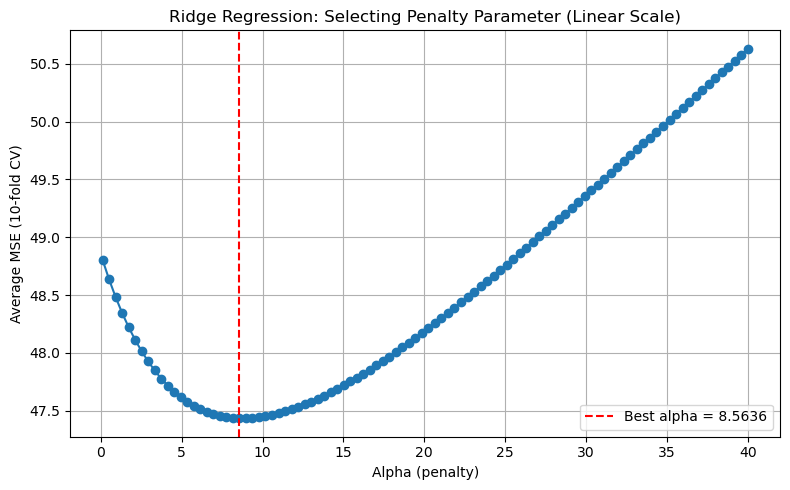

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


# Linearly spaced alpha values
alphas = np.linspace(0.1, 40, 100)

# Set up K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store average MSE for each alpha
avg_mse = []

for alpha in alphas:
    mse_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        # Fit Ridge regression
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

        # Predict and compute MSE
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_list.append(mse)

    avg_mse.append(np.mean(mse_list))

# Find best alpha
best_alpha = alphas[np.argmin(avg_mse)]
print(f"Best alpha: {best_alpha:.4f}")

# Plot MSE vs alpha (linear axis)
plt.figure(figsize=(8, 5))
plt.plot(alphas, avg_mse, marker='o')
plt.xlabel('Alpha (penalty)')
plt.ylabel('Average MSE (10-fold CV)')
plt.title('Ridge Regression: Selecting Penalty Parameter (Linear Scale)')
plt.grid(True)
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Best alpha = {best_alpha:.4f}')
plt.legend()
plt.tight_layout()
plt.show()



Here, the cross-validation curve has a very clear minimum (note that this does not always happen). This is the value we should use for our Ridge parameter. 

## Model assessment

The above cross-validation procedure can be used to select a model that will generalize well to new data. Having chosen a final model, we often want to estimate its prediction error (generalization error) on new data. Generally speaking, the cross-validation error provides a good estimate of the prediction error. However, when enough data is available, a good practice is to keep some data completely separate for final testing.

```{figure} images/train-test.jpg
---
width: 500 px
---
```

```{admonition} Important
Whenever possible, one should split the dataset into a training and a testing set. Cross-validation can be performed on the training set to select an optimal model. After training, one can then evaluate the final model on the test set to get a better idea of its generalization error on data that has never been seen before. Extra care should be taken to make sure the training and test samples are chosen uniformly at random. Similarly, the folds used during cross-validation should be chosen at random.
```